In [1]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import LineString, Point

# Load trip data
trip_data_path = (r"C:\Users\kriti\kriti python\df_trips_202401.csv")
df = pd.read_csv(trip_data_path)

# Convert start time and filter by weekday
df['start_time'] = pd.to_datetime(df['START_TIME_RAW'], unit='ms', errors='coerce')
df['weekday'] = df['start_time'].dt.day_name()
df = df[df['weekday'].isin(['Wednesday', 'Sunday'])].copy()

# Convert ROUTE column to LineString geometry
def extract_linestring(route_json):
    try:
        route = json.loads(route_json)
        coords = [f['geometry']['coordinates'] for f in route['features']]
        if len(coords) > 1:
            return LineString(coords)
    except:
        return None

df['geometry'] = df['ROUTE'].apply(extract_linestring)
df = df[df['geometry'].notnull()].copy()

# Create GeoDataFrame
scooter_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Extract pickup and dropoff points
scooter_gdf['pickup_point'] = scooter_gdf['geometry'].apply(lambda line: Point(line.coords[0]) if line else None)
scooter_gdf['dropoff_point'] = scooter_gdf['geometry'].apply(lambda line: Point(line.coords[-1]) if line else None)

# Create pickup and dropoff GeoDataFrames (optional if needed separately)
gdf_pickups = gpd.GeoDataFrame(scooter_gdf, geometry='pickup_point', crs='EPSG:4326')
gdf_dropoffs = gpd.GeoDataFrame(scooter_gdf, geometry='dropoff_point', crs='EPSG:4326')


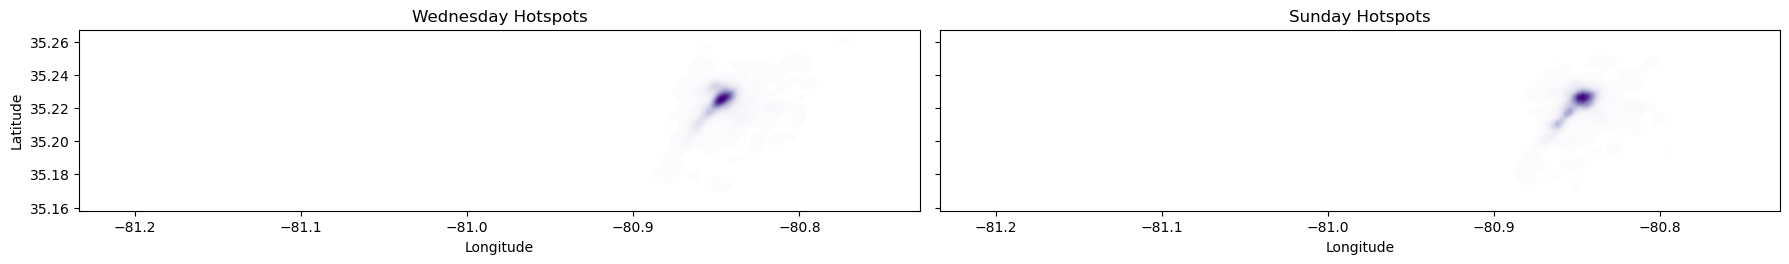

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter by weekday
wed_gdf = scooter_gdf[scooter_gdf['weekday'] == 'Wednesday'].copy()
sun_gdf = scooter_gdf[scooter_gdf['weekday'] == 'Sunday'].copy()

# Step 2: Extract pickup + dropoff coordinates as one set for each day
def get_combined_xy(df):
    pickup = df['pickup_point'].apply(lambda pt: (pt.x, pt.y)).tolist()
    dropoff = df['dropoff_point'].apply(lambda pt: (pt.x, pt.y)).tolist()
    all_coords = pickup + dropoff
    return zip(*all_coords)

x_wed, y_wed = get_combined_xy(wed_gdf)
x_sun, y_sun = get_combined_xy(sun_gdf)

# Step 3: Set zoom bounding box
all_x = list(x_wed) + list(x_sun)
all_y = list(y_wed) + list(y_sun)
x_min, x_max = min(all_x) - 0.005, max(all_x) + 0.005
y_min, y_max = min(all_y) - 0.005, max(all_y) + 0.005

# Step 4: Re-extract (zip resets after use)
x_wed, y_wed = get_combined_xy(wed_gdf)
x_sun, y_sun = get_combined_xy(sun_gdf)

# Step 5: Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharex=True, sharey=True)

# Wednesday
sns.kdeplot(x=x_wed, y=y_wed, ax=axes[0], cmap="Purples", fill=True, levels=100, thresh=0.01)
axes[0].set_title("Wednesday Hotspots")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_aspect("equal", adjustable="box")

# Sunday
sns.kdeplot(x=x_sun, y=y_sun, ax=axes[1], cmap="Purples", fill=True, levels=100, thresh=0.01)
axes[1].set_title("Sunday Hotspots")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


C:\Users\kriti\AppData\Local\Temp\ipykernel_17684\1363685478.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma', 5)


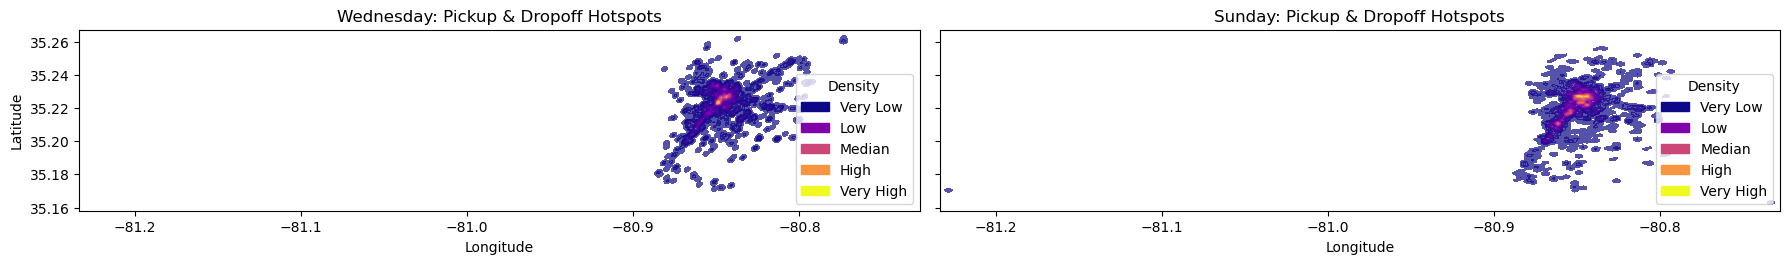

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# Reuse x_wed, y_wed, x_sun, y_sun from earlier
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharex=True, sharey=True)

# Updated KDE settings for better clarity and visibility
kde_kwargs = {
    'fill': True,
    'levels': 30,              # Reduced from 100 to avoid level errors
    'thresh': 0.001,
    'bw_adjust': 0.3,
    'alpha': 0.7,
    'cmap': 'plasma'           # You can change this to 'viridis', 'magma', etc.
}


# Wednesday plot
sns.kdeplot(x=x_wed, y=y_wed, ax=axes[0], **kde_kwargs)
axes[0].set_title("Wednesday: Pickup & Dropoff Hotspots")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_aspect("equal", adjustable="box")

# Sunday plot
sns.kdeplot(x=x_sun, y=y_sun, ax=axes[1], **kde_kwargs)
axes[1].set_title("Sunday: Pickup & Dropoff Hotspots")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_aspect("equal", adjustable="box")

density_labels = ['Very Low', 'Low', 'Median', 'High', 'Very High']
plasma = cm.get_cmap('plasma', 5)
density_colors = [plasma(i) for i in range(5)]
density_legend = [mpatches.Patch(color=density_colors[i], label=density_labels[i]) for i in range(5)]

for ax in axes:
    ax.legend(handles=density_legend, title="Density", loc='lower right', frameon=True)
plt.tight_layout()
plt.show()


In [4]:
import geopandas as gpd

# Load bus stops
bus_stops_path = (r"C:\Users\kriti\Bus_Stops_With_Frequency_HLT.geojson")
bus_stops_gdf = gpd.read_file(bus_stops_path)

# Load LYNX Blue Line stations
stations_path = (r"C:\Users\kriti\LYNX_Blue_Line_Stations.geojson")
stations_gdf = gpd.read_file(stations_path)

# Load LYNX Blue Line route
route_path = (r"C:\Users\kriti\LYNX_Blue_Line_Route.geojson")
blue_line_route_gdf = gpd.read_file(route_path)


C:\Users\kriti\AppData\Local\Temp\ipykernel_17684\3037348333.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma = cm.get_cmap('plasma', 5)


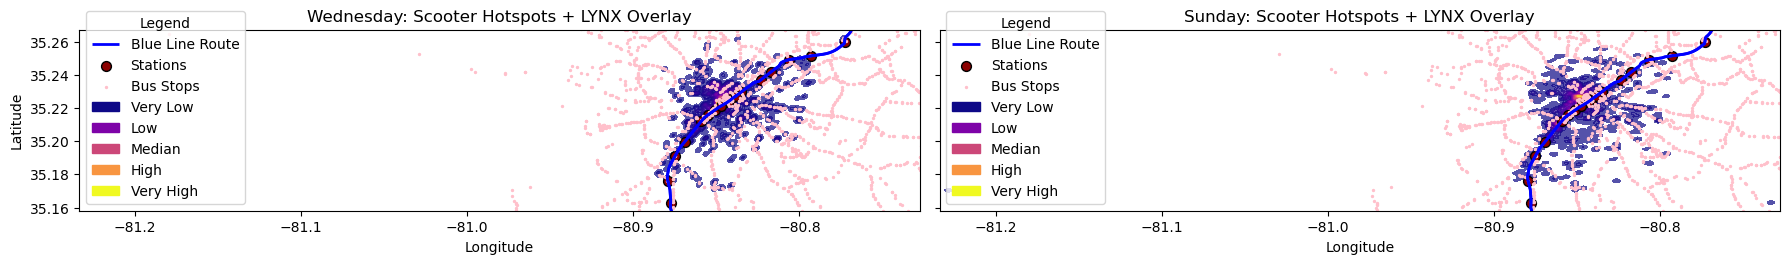

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# 1. Recalculate x/y for combined points
def get_combined_xy(df):
    pickup = df['pickup_point'].apply(lambda pt: (pt.x, pt.y)).tolist()
    dropoff = df['dropoff_point'].apply(lambda pt: (pt.x, pt.y)).tolist()
    all_coords = pickup + dropoff
    return zip(*all_coords)

x_wed, y_wed = get_combined_xy(wed_gdf)
x_sun, y_sun = get_combined_xy(sun_gdf)

# 2. Bounding box
all_x = list(x_wed) + list(x_sun)
all_y = list(y_wed) + list(y_sun)
x_min, x_max = min(all_x) - 0.005, max(all_x) + 0.005
y_min, y_max = min(all_y) - 0.005, max(all_y) + 0.005

# 3. Re-extract to reset zip
x_wed, y_wed = get_combined_xy(wed_gdf)
x_sun, y_sun = get_combined_xy(sun_gdf)

# 4. KDE style
kde_style = {
    'fill': True,
    'levels': 30,
    'thresh': 0.001,
    'bw_adjust': 0.3,
    'alpha': 0.7,
    'cmap': 'plasma'
}

# 5. Setup plot
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharex=True, sharey=True)

# 6. Add density legend matching plasma colormap
density_labels = ['Very Low', 'Low', 'Median', 'High', 'Very High']
plasma = cm.get_cmap('plasma', 5)
density_colors = [plasma(i) for i in range(5)]
density_legend = [mpatches.Patch(color=density_colors[i], label=density_labels[i]) for i in range(5)]

# ------- LEFT: Wednesday -------
sns.kdeplot(x=x_wed, y=y_wed, ax=axes[0], **kde_style)
blue_line_route_gdf.plot(ax=axes[0], color='blue', linewidth=2, label='Blue Line Route')
stations_gdf.plot(ax=axes[0], color='darkred', edgecolor='black', markersize=50, label='Stations')
bus_stops_gdf.plot(ax=axes[0], color='pink', markersize=2, label='Bus Stops')
axes[0].set_title("Wednesday: Scooter Hotspots + LYNX Overlay")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_aspect("equal", adjustable="box")
# Get existing legend handles (route, stations, bus stops)
handles, labels = axes[0].get_legend_handles_labels()
combined_legend = handles + density_legend
combined_labels = labels + density_labels

axes[0].legend(combined_legend, combined_labels, title="Legend", loc='lower left', frameon=True)


# ------- RIGHT: Sunday -------
sns.kdeplot(x=x_sun, y=y_sun, ax=axes[1], **kde_style)
blue_line_route_gdf.plot(ax=axes[1], color='blue', linewidth=2, label='Blue Line Route')
stations_gdf.plot(ax=axes[1], color='darkred', edgecolor='black', markersize=50, label='Stations')
bus_stops_gdf.plot(ax=axes[1], color='pink', markersize=2, label='Bus Stops')
axes[1].set_title("Sunday: Scooter Hotspots + LYNX Overlay")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_aspect("equal", adjustable="box")
handles, labels = axes[1].get_legend_handles_labels()
combined_legend = handles + density_legend
combined_labels = labels + density_labels

axes[1].legend(combined_legend, combined_labels, title="Legend", loc='lower left', frameon=True)


plt.tight_layout()
plt.show()
